In [2]:
import numpy as np
import matplotlib as mpl
mpl.use('pgf')

def figsize(scale):
    fig_width_pt = 427.3153                         # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(0.9),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width):
    plt.clf()
    fig = plt.figure(figsize=figsize(width))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename):
    plt.savefig('../../text/figures/plots/{}.pgf'.format(filename), bbox_inches='tight')
    plt.savefig('../../text/figures/plots/{}.pdf'.format(filename), bbox_inches='tight')

%matplotlib inline

import pandas as pd

import json
import glob
import os

In [3]:
data = {}

for path in glob.glob(os.path.expanduser("~/dev/ma/data/results/level0cluster/*.json")):
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [4]:
frames['program_run']['order'] = frames['program_run']['graph'].map(lambda x: 'shuffled' if "uk-2002.metis-preprocessed" in x else 'original')

partitions = frames['partition']
partitions['algorithm'] = frames['partition'] \
    .merge(frames['program_run'], how='left', left_on='program_run_id', right_index=True) \
    .apply(lambda x: x.binary if x.algorithm == 'external' else x.algorithm, axis=1)
    
partitions.replace({ 'algorithm': { 'deterministic_greedy_with_linear_penalty': 'streaming', 'label_prop_partitioning': 'label propagation' } }, inplace=True)
    
graphs = frames['program_run'].loc[lambda x: x.binary == './louvain'] # .loc[lambda x: x.graph.str.contains("uk-2002.metis-preprocessed")]
algos = frames['algorithm_run'].merge(graphs, left_on='program_run_id', right_index=True)

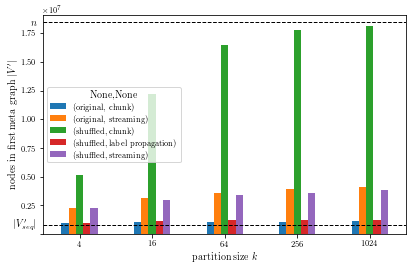

In [74]:
seq_cluster_count = frames['algorithm_level'] \
    .loc[lambda x: x.level == 0] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(graphs, left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.algorithm.str.contains("sequential")] \
    ['cluster_count'] \
    .mean()
node_count = frames['program_run']['node_count'].iloc[0]

groups = frames['algorithm_level'] \
    .loc[lambda x: x.level == 0] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(graphs, left_on='program_run_id', right_index=True) \
    .merge(partitions, left_on='partition_id', right_index=True) \
    .loc[lambda x: x.algorithm_x.str.contains("partitioned")] \
    .loc[lambda x: x.allow_move_to_ghosts] \
    .groupby(['order', 'algorithm_y'], as_index=False)

#    .loc[lambda x: ~x.algorithm_y.isin(["deterministic_greedy_with_linear_penalty"])] \

plot = pd.DataFrame({algo: levels.groupby('size')['cluster_count'].mean() for algo, levels in groups}).plot.bar(figsize=figsize(1.1), rot=0)
plot.set_ylabel("nodes in first meta graph $|V'|$")
plot.set_xlabel("partition size $k$")
plt.axhline(seq_cluster_count, color='k', linestyle='dashed', linewidth=1)
plt.axhline(node_count, color='k', linestyle='dashed', linewidth=1)

plt.text(-0.67, node_count - 250000, '$n$')
plt.text(-0.9, seq_cluster_count - 250000, "$|V'_{seq}|$")
plt.setp(plot.get_yticklabels()[0], visible=False)
savefig('level0cluster')